# 基于MindSpore实现目标检测示例

参考资料：[【MindSpore】使用YOLOv3实现目标检测](https://developer.huaweicloud.com/develop/aigallery/notebook/detail?id=6b88bd97-c2c0-45f2-8dde-7c4bd5889905)

## 简介
目标检测是很多计算机视觉应用的基础，比如实例分割等，它结合了目标分类和定位两个任务。

深度学习用于目标检测的算法从思路上来看，可以分为两大类，一类是two stage的方法，也就是把整个分为两部分，生成候选框和识别框内物体，例如R-CNN系列；另一类是one stage的方法，把整个流程统一在一起，直接给出检测结果，主要包含SSD,YOLO系列。

目标检测的backbone一般基于ImageNet预训练的图像分类网络。图像分类问题只关注分类和感受视野，不用关注物体定位，但是目标检测领域同时很关注空间信息。如果下采样过多，会导致最后的feature map很小，小目标很容易漏掉。很多基础架构网络，比如ResNet、FPN等神经网络提取图像的上下文信息，不断在特征提取方向优化。

### YOLO网络介绍
YOLO是单阶段方法的开山之作。它将检测任务表述成一个统一的、端到端的回归问题，并且以只处理一次图片同时得到位置和分类而得名。

**YOLOV1**是典型的目标检测one stage方法，用回归的方法去做目标检测，执行速度快，达到非常高效的检测。YOLOV1的基本思想是把一副图片，首先reshape成448×448大小（由于网络中使用了全连接层，所以图片的尺寸需固定大小输入到CNN中），然后将划分成SxS个单元格（原文中S=7），如果目标中心点在某个单元格内，该单元格就负责预测该目标。输出层的大小为7x7，通道数为30。7x7可以看作将原图分为7x7的网格，而每个格子中有30个数。这三十个数分别对应了两组（意味着每个网格尝试着预测两个边界框）的“位置信息+置信度”以及20个类别（VOC数据集中有20个类别）。
![yolov1](./image/yolov1.png )
<center>yolov1预测示意图</center>

![yolov1输出层](./image/yolov1_out.png)
<center>yolov1输出层</center>

**YOLOV2**，选择了5个锚作为召回率和模型复杂度之间的良好折衷。其关键特点：

1）Batch Normalization: YOLOv1没有使用BN层，而YOLOv2在每一层卷积层后都使用了BN层，BN层通过训练数据学习每一层每个神经元的缩放比例，进行标准化。BN层可以帮助网络进行训练，原论文指出，卷积层加了BN层后就可以不用dropout了，使用BN层后可以提高2%的mAP。顺便一提的是，卷积层后加了BN层时，卷积层可以不使用偏置值。

2）High Resolution Classifier: 对YOLOV2，预训练之后，在ImageNet数据集上，用448*448大小的图片对分类网络进行微调，大约10个epoches，其目的是让网络先学习一下高分辨率的图片，之后再应用到检测网络中，这个举措使得mAP提升大概4%。

3）Convolutional With Anchor Boxes: YOLOv1并没有使用锚点，而是直接预测x,y,w,h，且每个网格预测两个边界框的形式总觉得很奇怪（因为同一个网格中的两个边界框并没有什么不同）。而YOLOv2引用了Faster RCNN和SSD模型中的锚点，预测的位置是相对预置的锚点的。论文指出通过使用锚点，mAP下降了0.3%的mAP，但是召回率增加了7%，虽然mAP下降了，但是更高的召回率意味着模型的上限更高。

4）Dimension Cluster: 对网络来说，如果能够选择合适的anchor尺寸，网络更加容易学习并且预测出更好的结果，在论文中作者使用k-means算法在训练集上的边界框中自动选择合适的box dimensions。

5）Direct location prediction: 作者在论文中提到，需要对x,y,w,h进行归一化（在输出层代表位置信息的部分使用sigmoid激活函数）。此外，置信度同样也需要进行归一化（输出层代码置信度的位置加sigmoid激活函数）。这样可以是的网络在训练过程中更加稳定。通过Dimension Clusters和Direct location prediction可以使模型提高5%的mAP。

6）Fine-Grained Features:在13*13特征图上进行目标检测，对于一些大的目标是足够的，但是对于小物体的检测还需要细粒度的特征，为此YOLOV2添加一个passthrough layer，将浅层的特征和深层的特征，两个不同尺寸的特征按通道维度拼接起来。值得一提的是，原论文中，作者写的是PassThrough层将26x26x512的特征图变为13x13x2048的特征图，但是实际上，在作者的代码实现中，在PassThrough层前使用了1x1的卷积将512维的通道数减少到了64维。因此，实际上，PassThrough层的输入为26x26x64，输出为13x13x256。而YOLOv2的最终网络结构如下图所示。

7） Multi-Scale training：从上面的结构图可以看到，YOLOv2相比YOLOv1，去掉了全连接层，所有带参数的网络层均为卷积层和BN层（在表格中没画出来，每个卷积层后面都会跟一个BN层）。卷积层和BN层都不会受到输入图像大小的影响（如果网络有全连接层，输入图像的大小必须是一致的）。因此，作者提出，在训练模型时可以使用不同尺度的图像进行训练来保证模型对大目标和小目标都能达到不错的效果。由于网络的输入图像的大小为输出大小的32倍，因此，作者使用了多个尺寸为32倍数的图像对网络进行训练。输入图像的大小为{320，352，...，608}，每十个batch换一组尺寸。
![yolov1输出层](./image/yolov2.png)
<center>yolov2网络结构</center>


**YOLOv3**相比YOLOv2最大的改进点在于借鉴了SSD的多尺度判别，即在不同大小的特征图上进行预测。对于网络前几层的大尺寸特征图，可以有效地检测出小目标，对于网络最后的小尺寸特征图可以有效地检测出大目标。此外，YOLOv3的backbone选择了DarkNet53网络，网络结构更深，特征提取能力更强了。

YOLOv3的网络结构如下图所示，左侧中的红色框部分为去掉输出层的DarkNet53网络：
![yolov1输出层](./image/yolov3.png)
<center>yolov3网络结构</center>

YOLOv3网络结构，有以下几点需要注意的：

  1.    由于网络较深，使用了残差结构。
  2.    DarkNet53网络用步长为2的卷积代替了池化层。
  3.    所有的网络层不包含全连接层，因此，输入图像的大小也是可以调整的（有些地方看到的可能是608x608，其实是一样的），而输入图像的大小同样是最小的输出特征图的32倍。
  4.    YOLOv3分别在三个尺寸的特征图进行了预测，每个尺寸的特征图使用了3个锚点。因此，输出层的维度计算方法为：(4+1+80)x3=255，因此，最后一层1x1的卷积层的数量为255。
  5.    13 x 13的特征图会通过上采样层和之前的26 x 26的特征图在通道维度拼接在一起，26 x 26的特征图再经过上采样和52 x 52的特征图拼接。

## 实验目标
通过学习本实验，实现基于mindspore的目标检测，可以帮助熟悉MindSpore深度学习框架

## 实验步骤
### 1. 定义数据处理相关函数
以下代码用于定义相关数据集预处理的函数，如：生成Mindrecord文件，生成数据集对象等。

In [1]:
# 从OBS中拷贝数据集，此处路径视情况不用修改。
#也可从其他途径获取数据，以.ipynb文件所在地址为当前目录，将数据放在./data内解压即可
'''
import moxing as mox
mox.file.copy_parallel(src_url="obs:272aeacd8d6a4d01a4133b11869c8877/lzu/31/data.zip",dst_url="./data/data.zip")
'''

'\nimport moxing as mox\nmox.file.copy_parallel(src_url="obs:272aeacd8d6a4d01a4133b11869c8877/lzu/31/data.zip",dst_url="./data/data.zip")\n'

In [2]:
# 创建文件夹，用于保存各功能代码
import os
code_dir = "./code/src"
if not os.path.exists(code_dir):
    os.makedirs(code_dir)

In [3]:
%%writefile ./code/src/dataset.py
"""YOLOv3 dataset"""
from __future__ import division

import os
from xml.dom.minidom import parse
import xml.dom.minidom

import numpy as np
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from PIL import Image
import mindspore.dataset as de
from mindspore.mindrecord import FileWriter
import mindspore.dataset.vision.c_transforms as C
from src.config import ConfigYOLOV3ResNet18

def preprocess_fn(image, box, file, is_training):
    """Preprocess function for dataset."""
    config_anchors = []
    temp = ConfigYOLOV3ResNet18.anchor_scales
    for i in temp:
        config_anchors+=list(i)
    
    anchors = np.array([float(x) for x in config_anchors]).reshape(-1, 2)
    do_hsv = False
    max_boxes = ConfigYOLOV3ResNet18._NUM_BOXES
    num_classes = ConfigYOLOV3ResNet18.num_classes

    def _rand(a=0., b=1.):
        return np.random.rand() * (b - a) + a

    def _preprocess_true_boxes(true_boxes, anchors, in_shape=None):
        """Get true boxes."""
        num_layers = anchors.shape[0] // 3
        anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        true_boxes = np.array(true_boxes, dtype='float32')
        input_shape = np.array(in_shape, dtype='int32')
        boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2.
        boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
        true_boxes[..., 0:2] = boxes_xy / input_shape[::-1]
        true_boxes[..., 2:4] = boxes_wh / input_shape[::-1]
        grid_shapes = [input_shape // 32, input_shape // 16, input_shape // 8]
        y_true = [np.zeros((grid_shapes[l][0], grid_shapes[l][1], len(anchor_mask[l]),
                            5 + num_classes), dtype='float32') for l in range(num_layers)]
        anchors = np.expand_dims(anchors, 0)
        anchors_max = anchors / 2.
        anchors_min = -anchors_max
        valid_mask = boxes_wh[..., 0] >= 1
        wh = boxes_wh[valid_mask]

        if len(wh) >= 1:
            wh = np.expand_dims(wh, -2)
            boxes_max = wh / 2.
            boxes_min = -boxes_max
            intersect_min = np.maximum(boxes_min, anchors_min)
            intersect_max = np.minimum(boxes_max, anchors_max)
            intersect_wh = np.maximum(intersect_max - intersect_min, 0.)
            intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
            box_area = wh[..., 0] * wh[..., 1]
            anchor_area = anchors[..., 0] * anchors[..., 1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            best_anchor = np.argmax(iou, axis=-1)
            for t, n in enumerate(best_anchor):
                for l in range(num_layers):
                    if n in anchor_mask[l]:
                        i = np.floor(true_boxes[t, 0] * grid_shapes[l][1]).astype('int32')
                        j = np.floor(true_boxes[t, 1] * grid_shapes[l][0]).astype('int32')
                        k = anchor_mask[l].index(n)

                        c = true_boxes[t, 4].astype('int32')
                        y_true[l][j, i, k, 0:4] = true_boxes[t, 0:4]
                        y_true[l][j, i, k, 4] = 1.
                        y_true[l][j, i, k, 5 + c] = 1.

        pad_gt_box0 = np.zeros(shape=[ConfigYOLOV3ResNet18._NUM_BOXES, 4], dtype=np.float32)
        pad_gt_box1 = np.zeros(shape=[ConfigYOLOV3ResNet18._NUM_BOXES, 4], dtype=np.float32)
        pad_gt_box2 = np.zeros(shape=[ConfigYOLOV3ResNet18._NUM_BOXES, 4], dtype=np.float32)

        mask0 = np.reshape(y_true[0][..., 4:5], [-1])
        gt_box0 = np.reshape(y_true[0][..., 0:4], [-1, 4])
        gt_box0 = gt_box0[mask0 == 1]
        pad_gt_box0[:gt_box0.shape[0]] = gt_box0

        mask1 = np.reshape(y_true[1][..., 4:5], [-1])
        gt_box1 = np.reshape(y_true[1][..., 0:4], [-1, 4])
        gt_box1 = gt_box1[mask1 == 1]
        pad_gt_box1[:gt_box1.shape[0]] = gt_box1

        mask2 = np.reshape(y_true[2][..., 4:5], [-1])
        gt_box2 = np.reshape(y_true[2][..., 0:4], [-1, 4])
        gt_box2 = gt_box2[mask2 == 1]
        pad_gt_box2[:gt_box2.shape[0]] = gt_box2

        return y_true[0], y_true[1], y_true[2], pad_gt_box0, pad_gt_box1, pad_gt_box2

    def _infer_data(img_data, input_shape, box):
        w, h = img_data.size
        input_h, input_w = input_shape
        scale = min(float(input_w) / float(w), float(input_h) / float(h))
        nw = int(w * scale)
        nh = int(h * scale)
        img_data = img_data.resize((nw, nh), Image.BICUBIC)

        new_image = np.zeros((input_h, input_w, 3), np.float32)
        new_image.fill(128)
        img_data = np.array(img_data)
        if len(img_data.shape) == 2:
            img_data = np.expand_dims(img_data, axis=-1)
            img_data = np.concatenate([img_data, img_data, img_data], axis=-1)

        dh = int((input_h - nh) / 2)
        dw = int((input_w - nw) / 2)
        new_image[dh:(nh + dh), dw:(nw + dw), :] = img_data
        new_image /= 255.
        new_image = np.transpose(new_image, (2, 0, 1))
        new_image = np.expand_dims(new_image, 0)
        return new_image, np.array([h, w], np.float32), box

    def _data_aug(image, box, is_training, jitter=0.3, hue=0.1, sat=1.5, val=1.5, image_size=(352, 640)):
        
        """Data augmentation function."""
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        iw, ih = image.size
        ori_image_shape = np.array([ih, iw], np.int32)
        h, w = image_size

        if not is_training:
            return _infer_data(image, image_size, box)

        flip = _rand() < .5
        # correct boxes
        box_data = np.zeros((max_boxes, 5))
        flag =0
        
        while True:
            # Prevent the situation that all boxes are eliminated
            new_ar = float(w) / float(h) * _rand(1 - jitter, 1 + jitter) / \
                     _rand(1 - jitter, 1 + jitter)
            scale = _rand(0.25, 2)

            if new_ar < 1:
                nh = int(scale * h)
                nw = int(nh * new_ar)
            else:
                nw = int(scale * w)
                nh = int(nw / new_ar)

            dx = int(_rand(0, w - nw))
            dy = int(_rand(0, h - nh))
            flag = flag + 1
            
            if len(box) >= 1:
                t_box = box.copy()
                np.random.shuffle(t_box)
                t_box[:, [0, 2]] = t_box[:, [0, 2]] * float(nw) / float(iw) + dx
                t_box[:, [1, 3]] = t_box[:, [1, 3]] * float(nh) / float(ih) + dy
                if flip:
                    t_box[:, [0, 2]] = w - t_box[:, [2, 0]]
                t_box[:, 0:2][t_box[:, 0:2] < 0] = 0
                t_box[:, 2][t_box[:, 2] > w] = w
                t_box[:, 3][t_box[:, 3] > h] = h
                box_w = t_box[:, 2] - t_box[:, 0]
                box_h = t_box[:, 3] - t_box[:, 1]
                t_box = t_box[np.logical_and(box_w > 1, box_h > 1)]  # discard invalid box

            if len(t_box) >= 1:
                box = t_box
                break

        box_data[:len(box)] = box
        # resize image
        image = image.resize((nw, nh), Image.BICUBIC)
        # place image
        new_image = Image.new('RGB', (w, h), (128, 128, 128))
        new_image.paste(image, (dx, dy))
        image = new_image

        # flip image or not
        if flip:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        # convert image to gray or not
        gray = _rand() < .25
        if gray:
            image = image.convert('L').convert('RGB')

        # when the channels of image is 1
        image = np.array(image)
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)
            image = np.concatenate([image, image, image], axis=-1)

        # distort image
        hue = _rand(-hue, hue)
        sat = _rand(1, sat) if _rand() < .5 else 1 / _rand(1, sat)
        val = _rand(1, val) if _rand() < .5 else 1 / _rand(1, val)
        image_data = image / 255.
        if do_hsv:
            x = rgb_to_hsv(image_data)
            x[..., 0] += hue
            x[..., 0][x[..., 0] > 1] -= 1
            x[..., 0][x[..., 0] < 0] += 1
            x[..., 1] *= sat
            x[..., 2] *= val
            x[x > 1] = 1
            x[x < 0] = 0
            image_data = hsv_to_rgb(x)  # numpy array, 0 to 1
        image_data = image_data.astype(np.float32)

        # preprocess bounding boxes
        bbox_true_1, bbox_true_2, bbox_true_3, gt_box1, gt_box2, gt_box3 = \
            _preprocess_true_boxes(box_data, anchors, image_size)

        return image_data, bbox_true_1, bbox_true_2, bbox_true_3, \
               ori_image_shape, gt_box1, gt_box2, gt_box3

    if is_training:
        images, bbox_1, bbox_2, bbox_3, image_shape, gt_box1, gt_box2, gt_box3 = _data_aug(image, box, is_training)
        return images, bbox_1, bbox_2, bbox_3, gt_box1, gt_box2, gt_box3

    images, shape, anno = _data_aug(image, box, is_training)
    return images, shape, anno, file


def xy_local(collection,element):
    xy = collection.getElementsByTagName(element)[0]
    xy = xy.childNodes[0].data
    return xy


def filter_valid_data(image_dir):
    """Filter valid image file, which both in image_dir and anno_path."""
    
    label_id={'person':0, 'face':1, 'mask':2}
    all_files = os.listdir(image_dir)

    image_dict = {}
    image_files=[]
    for i in all_files:
        if (i[-3:]=='jpg' or i[-4:]=='jpeg') and i not in image_dict:
            image_files.append(i)
            label=[]
            xml_path = os.path.join(image_dir,i[:-3]+'xml')
            
            if not os.path.exists(xml_path):
                label=[[0,0,0,0,0]]
                image_dict[i]=label
                continue
            DOMTree = xml.dom.minidom.parse(xml_path)
            collection = DOMTree.documentElement
            # 在集合中获取所有框
            object_ = collection.getElementsByTagName("object")
            for m in object_:
                temp=[]
                name = m.getElementsByTagName('name')[0]
                class_num = label_id[name.childNodes[0].data]
                bndbox = m.getElementsByTagName('bndbox')[0]
                xmin = xy_local(bndbox,'xmin')
                ymin = xy_local(bndbox,'ymin')
                xmax = xy_local(bndbox,'xmax')
                ymax = xy_local(bndbox,'ymax')
                temp.append(int(xmin))
                temp.append(int(ymin))
                temp.append(int(xmax))
                temp.append(int(ymax))
                temp.append(class_num)
                label.append(temp)
            image_dict[i]=label
    return image_files, image_dict


def data_to_mindrecord_byte_image(image_dir, mindrecord_dir, prefix, file_num):
    """Create MindRecord file by image_dir and anno_path."""
    mindrecord_path = os.path.join(mindrecord_dir, prefix)
    writer = FileWriter(mindrecord_path, file_num)
    image_files, image_anno_dict = filter_valid_data(image_dir)

    yolo_json = {
        "image": {"type": "bytes"},
        "annotation": {"type": "int32", "shape": [-1, 5]},
        "file": {"type": "string"},
    }
    writer.add_schema(yolo_json, "yolo_json")

    for image_name in image_files:
        image_path = os.path.join(image_dir, image_name)
        with open(image_path, 'rb') as f:
            img = f.read()
        annos = np.array(image_anno_dict[image_name],dtype=np.int32)
        #print(annos.shape)
        row = {"image": img, "annotation": annos, "file": image_name}
        writer.write_raw_data([row])
    writer.commit()


def create_yolo_dataset(mindrecord_dir, batch_size=32, repeat_num=1, device_num=1, rank=0,
                        is_training=True, num_parallel_workers=8):
    """Creatr YOLOv3 dataset with MindDataset."""
    ds = de.MindDataset(mindrecord_dir, columns_list=["image", "annotation","file"], num_shards=device_num, shard_id=rank,
                        num_parallel_workers=num_parallel_workers, shuffle=is_training)
    decode = C.Decode()
    ds = ds.map(operations=decode, input_columns=["image"])
    compose_map_func = (lambda image, annotation, file: preprocess_fn(image, annotation,file, is_training))

    if is_training:
        hwc_to_chw = C.HWC2CHW()
        ds = ds.map(operations=compose_map_func, input_columns=["image", "annotation","file"],
                    output_columns=["image", "bbox_1", "bbox_2", "bbox_3", "gt_box1", "gt_box2", "gt_box3"],
                    column_order=["image", "bbox_1", "bbox_2", "bbox_3", "gt_box1", "gt_box2", "gt_box3"],
                    num_parallel_workers=num_parallel_workers)
        ds = ds.map(operations=hwc_to_chw, input_columns=["image"], num_parallel_workers=num_parallel_workers)
        ds = ds.batch(batch_size, drop_remainder=True)
        ds = ds.repeat(repeat_num)
    else:
        ds = ds.map(operations=compose_map_func, input_columns=["image", "annotation","file"],
                    output_columns=["image", "image_shape", "annotation","file"],
                    column_order=["image", "image_shape", "annotation","file"],
                    num_parallel_workers=num_parallel_workers)
    return ds

Overwriting ./code/src/dataset.py


### 2. 定义网络
以下代码实现生成YOLO网络所需的相关类。

In [4]:
%%writefile ./code/src/yolov3.py
"""YOLOv3 based on ResNet18."""

import numpy as np
import mindspore as ms
import mindspore.nn as nn
from mindspore import context, Tensor
from mindspore.context import ParallelMode
from mindspore.parallel._auto_parallel_context import auto_parallel_context
from mindspore.communication.management import get_group_size
from mindspore.common.initializer import TruncatedNormal
from mindspore.ops import operations as P
from mindspore.ops import functional as F
from mindspore.ops import composite as C


def weight_variable():
    """Weight variable."""
    return TruncatedNormal(0.02)


class _conv2d(nn.Cell):
    """Create Conv2D with padding."""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(_conv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride, padding=0, pad_mode='same',
                              weight_init=weight_variable())
    def construct(self, x):
        x = self.conv(x)
        return x


def _fused_bn(channels, momentum=0.99):
    """Get a fused batchnorm."""
    return nn.BatchNorm2d(channels, momentum=momentum)


def _conv_bn_relu(in_channel,
                  out_channel,
                  ksize,
                  stride=1,
                  padding=0,
                  dilation=1,
                  alpha=0.1,
                  momentum=0.99,
                  pad_mode="same"):
    """Get a conv2d batchnorm and relu layer."""
    return nn.SequentialCell(
        [nn.Conv2d(in_channel,
                   out_channel,
                   kernel_size=ksize,
                   stride=stride,
                   padding=padding,
                   dilation=dilation,
                   pad_mode=pad_mode),
         nn.BatchNorm2d(out_channel, momentum=momentum),
         nn.LeakyReLU(alpha)]
    )


class BasicBlock(nn.Cell):
    """
    ResNet basic block.

    Args:
        in_channels (int): Input channel.
        out_channels (int): Output channel.
        stride (int): Stride size for the initial convolutional layer. Default:1.
        momentum (float): Momentum for batchnorm layer. Default:0.1.

    Returns:
        Tensor, output tensor.

    Examples:
        BasicBlock(3,256,stride=2,down_sample=True).
    """
    expansion = 1

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1,
                 momentum=0.99):
        super(BasicBlock, self).__init__()

        self.conv1 = _conv2d(in_channels, out_channels, 3, stride=stride)
        self.bn1 = _fused_bn(out_channels, momentum=momentum)
        self.conv2 = _conv2d(out_channels, out_channels, 3)
        self.bn2 = _fused_bn(out_channels, momentum=momentum)
        self.relu = P.ReLU()
        self.down_sample_layer = None
        self.downsample = (in_channels != out_channels)
        if self.downsample:
            self.down_sample_layer = _conv2d(in_channels, out_channels, 1, stride=stride)
        self.add = P.Add()

    def construct(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample:
            identity = self.down_sample_layer(identity)

        out = self.add(x, identity)
        out = self.relu(out)

        return out


class ResNet(nn.Cell):
    """
    ResNet network.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of different layers.
        in_channels (int): Input channel.
        out_channels (int): Output channel.
        num_classes (int): Class number. Default:100.

    Returns:
        Tensor, output tensor.

    Examples:
        ResNet(ResidualBlock,
               [3, 4, 6, 3],
               [64, 256, 512, 1024],
               [256, 512, 1024, 2048],
               100).
    """

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides=None,
                 num_classes=80):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of "
                             "layer_num, inchannel, outchannel list must be 4!")

        self.conv1 = _conv2d(3, 64, 7, stride=2)
        self.bn1 = _fused_bn(64)
        self.relu = P.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])

        self.num_classes = num_classes
        if num_classes:
            self.reduce_mean = P.ReduceMean(keep_dims=True)
            self.end_point = nn.Dense(out_channels[3], num_classes, has_bias=True,
                                      weight_init=weight_variable(),
                                      bias_init=weight_variable())
            self.squeeze = P.Squeeze(axis=(2, 3))

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make Layer for ResNet.

        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the initial convolutional layer.

        Returns:
            SequentialCell, the output layer.

        Examples:
            _make_layer(BasicBlock, 3, 128, 256, 2).
        """
        layers = []

        resblk = block(in_channel, out_channel, stride=stride)
        layers.append(resblk)

        for _ in range(1, layer_num - 1):
            resblk = block(out_channel, out_channel, stride=1)
            layers.append(resblk)

        resblk = block(out_channel, out_channel, stride=1)
        layers.append(resblk)

        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = c5
        if self.num_classes:
            out = self.reduce_mean(c5, (2, 3))
            out = self.squeeze(out)
            out = self.end_point(out)

        return c3, c4, out


def resnet18(class_num=10):
    """
    Get ResNet18 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet18 neural network.

    Examples:
        resnet18(100).
    """
    return ResNet(BasicBlock,
                  [2, 2, 2, 2],
                  [64, 64, 128, 256],
                  [64, 128, 256, 512],
                  [1, 2, 2, 2],
                  num_classes=class_num)


class YoloBlock(nn.Cell):
    """
    YoloBlock for YOLOv3.

    Args:
        in_channels (int): Input channel.
        out_chls (int): Middle channel.
        out_channels (int): Output channel.

    Returns:
        Tuple, tuple of output tensor,(f1,f2,f3).

    Examples:
        YoloBlock(1024, 512, 255).

    """
    def __init__(self, in_channels, out_chls, out_channels):
        super(YoloBlock, self).__init__()
        out_chls_2 = out_chls * 2

        self.conv0 = _conv_bn_relu(in_channels, out_chls, ksize=1)
        self.conv1 = _conv_bn_relu(out_chls, out_chls_2, ksize=3)

        self.conv2 = _conv_bn_relu(out_chls_2, out_chls, ksize=1)
        self.conv3 = _conv_bn_relu(out_chls, out_chls_2, ksize=3)

        self.conv4 = _conv_bn_relu(out_chls_2, out_chls, ksize=1)
        self.conv5 = _conv_bn_relu(out_chls, out_chls_2, ksize=3)

        self.conv6 = nn.Conv2d(out_chls_2, out_channels, kernel_size=1, stride=1, has_bias=True)

    def construct(self, x):
        c1 = self.conv0(x)
        c2 = self.conv1(c1)

        c3 = self.conv2(c2)
        c4 = self.conv3(c3)

        c5 = self.conv4(c4)
        c6 = self.conv5(c5)

        out = self.conv6(c6)
        return c5, out


class YOLOv3(nn.Cell):
    """
     YOLOv3 Network.

     Note:
         backbone = resnet18.

     Args:
         feature_shape (list): Input image shape, [N,C,H,W].
         backbone_shape (list): resnet18 output channels shape.
         backbone (Cell): Backbone Network.
         out_channel (int): Output channel.

     Returns:
         Tensor, output tensor.

     Examples:
         YOLOv3(feature_shape=[1,3,416,416],
                backbone_shape=[64, 128, 256, 512, 1024]
                backbone=darknet53(),
                out_channel=255).
     """
    def __init__(self, feature_shape, backbone_shape, backbone, out_channel):
        super(YOLOv3, self).__init__()
        self.out_channel = out_channel
        self.net = backbone
        self.backblock0 = YoloBlock(backbone_shape[-1], out_chls=backbone_shape[-2], out_channels=out_channel)

        self.conv1 = _conv_bn_relu(in_channel=backbone_shape[-2], out_channel=backbone_shape[-2]//2, ksize=1)
        self.upsample1 = P.ResizeNearestNeighbor((feature_shape[2]//16, feature_shape[3]//16))
        self.backblock1 = YoloBlock(in_channels=backbone_shape[-2]+backbone_shape[-3],
                                    out_chls=backbone_shape[-3],
                                    out_channels=out_channel)

        self.conv2 = _conv_bn_relu(in_channel=backbone_shape[-3], out_channel=backbone_shape[-3]//2, ksize=1)
        self.upsample2 = P.ResizeNearestNeighbor((feature_shape[2]//8, feature_shape[3]//8))
        self.backblock2 = YoloBlock(in_channels=backbone_shape[-3]+backbone_shape[-4],
                                    out_chls=backbone_shape[-4],
                                    out_channels=out_channel)
        self.concat = P.Concat(axis=1)

    def construct(self, x):
        # input_shape of x is (batch_size, 3, h, w)
        # feature_map1 is (batch_size, backbone_shape[2], h/8, w/8)
        # feature_map2 is (batch_size, backbone_shape[3], h/16, w/16)
        # feature_map3 is (batch_size, backbone_shape[4], h/32, w/32)
        feature_map1, feature_map2, feature_map3 = self.net(x)
        con1, big_object_output = self.backblock0(feature_map3)

        con1 = self.conv1(con1)
        ups1 = self.upsample1(con1)
        con1 = self.concat((ups1, feature_map2))
        con2, medium_object_output = self.backblock1(con1)

        con2 = self.conv2(con2)
        ups2 = self.upsample2(con2)
        con3 = self.concat((ups2, feature_map1))
        _, small_object_output = self.backblock2(con3)

        return big_object_output, medium_object_output, small_object_output


class DetectionBlock(nn.Cell):
    """
     YOLOv3 detection Network. It will finally output the detection result.

     Args:
         scale (str): Character, scale.
         config (Class): YOLOv3 config.

     Returns:
         Tuple, tuple of output tensor,(f1,f2,f3).

     Examples:
         DetectionBlock(scale='l',stride=32).
     """

    def __init__(self, scale, config):
        super(DetectionBlock, self).__init__()

        self.config = config
        if scale == 's':
            idx = (0, 1, 2)
        elif scale == 'm':
            idx = (3, 4, 5)
        elif scale == 'l':
            idx = (6, 7, 8)
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = Tensor([self.config.anchor_scales[i] for i in idx], ms.float32)
        self.num_anchors_per_scale = 3
        self.num_attrib = 4 + 1 + self.config.num_classes
        self.ignore_threshold = 0.5
        self.lambda_coord = 1

        self.sigmoid = nn.Sigmoid()
        self.reshape = P.Reshape()
        self.tile = P.Tile()
        self.concat = P.Concat(axis=-1)
        self.input_shape = Tensor(tuple(config.img_shape[::-1]), ms.float32)

    def construct(self, x):
        num_batch = P.Shape()(x)[0]
        grid_size = P.Shape()(x)[2:4]

        # Reshape and transpose the feature to [n, 3, grid_size[0], grid_size[1], num_attrib]
        prediction = P.Reshape()(x, (num_batch,
                                     self.num_anchors_per_scale,
                                     self.num_attrib,
                                     grid_size[0],
                                     grid_size[1]))
        prediction = P.Transpose()(prediction, (0, 3, 4, 1, 2))

        range_x = range(grid_size[1])
        range_y = range(grid_size[0])
        grid_x = P.Cast()(F.tuple_to_array(range_x), ms.float32)
        grid_y = P.Cast()(F.tuple_to_array(range_y), ms.float32)
        # Tensor of shape [grid_size[0], grid_size[1], 1, 1] representing the coordinate of x/y axis for each grid
        grid_x = self.tile(self.reshape(grid_x, (1, 1, -1, 1, 1)), (1, grid_size[0], 1, 1, 1))
        grid_y = self.tile(self.reshape(grid_y, (1, -1, 1, 1, 1)), (1, 1, grid_size[1], 1, 1))
        # Shape is [grid_size[0], grid_size[1], 1, 2]
        grid = self.concat((grid_x, grid_y))

        box_xy = prediction[:, :, :, :, :2]
        box_wh = prediction[:, :, :, :, 2:4]
        box_confidence = prediction[:, :, :, :, 4:5]
        box_probs = prediction[:, :, :, :, 5:]

        box_xy = (self.sigmoid(box_xy) + grid) / P.Cast()(F.tuple_to_array((grid_size[1], grid_size[0])), ms.float32)
        box_wh = P.Exp()(box_wh) * self.anchors / self.input_shape
        box_confidence = self.sigmoid(box_confidence)
        box_probs = self.sigmoid(box_probs)

        if self.training:
            return grid, prediction, box_xy, box_wh
        return box_xy, box_wh, box_confidence, box_probs


class Iou(nn.Cell):
    """Calculate the iou of boxes."""
    def __init__(self):
        super(Iou, self).__init__()
        self.min = P.Minimum()
        self.max = P.Maximum()

    def construct(self, box1, box2):
        box1_xy = box1[:, :, :, :, :, :2]
        box1_wh = box1[:, :, :, :, :, 2:4]
        box1_mins = box1_xy - box1_wh / F.scalar_to_array(2.0)
        box1_maxs = box1_xy + box1_wh / F.scalar_to_array(2.0)

        box2_xy = box2[:, :, :, :, :, :2]
        box2_wh = box2[:, :, :, :, :, 2:4]
        box2_mins = box2_xy - box2_wh / F.scalar_to_array(2.0)
        box2_maxs = box2_xy + box2_wh / F.scalar_to_array(2.0)

        intersect_mins = self.max(box1_mins, box2_mins)
        intersect_maxs = self.min(box1_maxs, box2_maxs)
        intersect_wh = self.max(intersect_maxs - intersect_mins, F.scalar_to_array(0.0))

        intersect_area = P.Squeeze(-1)(intersect_wh[:, :, :, :, :, 0:1]) * \
                         P.Squeeze(-1)(intersect_wh[:, :, :, :, :, 1:2])
        box1_area = P.Squeeze(-1)(box1_wh[:, :, :, :, :, 0:1]) * P.Squeeze(-1)(box1_wh[:, :, :, :, :, 1:2])
        box2_area = P.Squeeze(-1)(box2_wh[:, :, :, :, :, 0:1]) * P.Squeeze(-1)(box2_wh[:, :, :, :, :, 1:2])

        iou = intersect_area / (box1_area + box2_area - intersect_area)
        return iou


class YoloLossBlock(nn.Cell):
    """
     YOLOv3 Loss block cell. It will finally output loss of the scale.

     Args:
         scale (str): Three scale here, 's', 'm' and 'l'.
         config (Class): The default config of YOLOv3.

     Returns:
         Tensor, loss of the scale.

     Examples:
         YoloLossBlock('l', ConfigYOLOV3ResNet18()).
     """

    def __init__(self, scale, config):
        super(YoloLossBlock, self).__init__()
        self.config = config
        if scale == 's':
            idx = (0, 1, 2)
        elif scale == 'm':
            idx = (3, 4, 5)
        elif scale == 'l':
            idx = (6, 7, 8)
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = Tensor([self.config.anchor_scales[i] for i in idx], ms.float32)
        self.ignore_threshold = Tensor(self.config.ignore_threshold, ms.float32)
        self.concat = P.Concat(axis=-1)
        self.iou = Iou()
        self.cross_entropy = P.SigmoidCrossEntropyWithLogits()
        self.reduce_sum = P.ReduceSum()
        self.reduce_max = P.ReduceMax(keep_dims=False)
        self.input_shape = Tensor(tuple(config.img_shape[::-1]), ms.float32)

    def construct(self, grid, prediction, pred_xy, pred_wh, y_true, gt_box):

        object_mask = y_true[:, :, :, :, 4:5]
        class_probs = y_true[:, :, :, :, 5:]

        grid_shape = P.Shape()(prediction)[1:3]
        grid_shape = P.Cast()(F.tuple_to_array(grid_shape[::-1]), ms.float32)

        pred_boxes = self.concat((pred_xy, pred_wh))
        true_xy = y_true[:, :, :, :, :2] * grid_shape - grid
        true_wh = y_true[:, :, :, :, 2:4]
        true_wh = P.Select()(P.Equal()(true_wh, 0.0),
                             P.Fill()(P.DType()(true_wh), P.Shape()(true_wh), 1.0),
                             true_wh)
        true_wh = P.Log()(true_wh / self.anchors * self.input_shape)
        box_loss_scale = 2 - y_true[:, :, :, :, 2:3] * y_true[:, :, :, :, 3:4]

        gt_shape = P.Shape()(gt_box)
        gt_box = P.Reshape()(gt_box, (gt_shape[0], 1, 1, 1, gt_shape[1], gt_shape[2]))

        iou = self.iou(P.ExpandDims()(pred_boxes, -2), gt_box) # [batch, grid[0], grid[1], num_anchor, num_gt]
        best_iou = self.reduce_max(iou, -1) # [batch, grid[0], grid[1], num_anchor]
        ignore_mask = best_iou < self.ignore_threshold
        ignore_mask = P.Cast()(ignore_mask, ms.float32)
        ignore_mask = P.ExpandDims()(ignore_mask, -1)
        ignore_mask = F.stop_gradient(ignore_mask)

        xy_loss = object_mask * box_loss_scale * self.cross_entropy(prediction[:, :, :, :, :2], true_xy)
        wh_loss = object_mask * box_loss_scale * 0.5 * P.Square()(true_wh - prediction[:, :, :, :, 2:4])
        confidence_loss = self.cross_entropy(prediction[:, :, :, :, 4:5], object_mask)
        confidence_loss = object_mask * confidence_loss + (1 - object_mask) * confidence_loss * ignore_mask
        class_loss = object_mask * self.cross_entropy(prediction[:, :, :, :, 5:], class_probs)

        # Get smooth loss
        xy_loss = self.reduce_sum(xy_loss, ())
        wh_loss = self.reduce_sum(wh_loss, ())
        confidence_loss = self.reduce_sum(confidence_loss, ())
        class_loss = self.reduce_sum(class_loss, ())

        loss = xy_loss + wh_loss + confidence_loss + class_loss
        return loss / P.Shape()(prediction)[0]


class yolov3_resnet18(nn.Cell):
    """
    ResNet based YOLOv3 network.

    Args:
        config (Class): YOLOv3 config.

    Returns:
        Cell, cell instance of ResNet based YOLOv3 neural network.

    Examples:
        yolov3_resnet18(80, [1,3,416,416]).
    """

    def __init__(self, config):
        super(yolov3_resnet18, self).__init__()
        self.config = config

        # YOLOv3 network
        self.feature_map = YOLOv3(feature_shape=self.config.feature_shape,
                                  backbone=ResNet(BasicBlock,
                                                  self.config.backbone_layers,
                                                  self.config.backbone_input_shape,
                                                  self.config.backbone_shape,
                                                  self.config.backbone_stride,
                                                  num_classes=None),
                                  backbone_shape=self.config.backbone_shape,
                                  out_channel=self.config.out_channel)

        # prediction on the default anchor boxes
        self.detect_1 = DetectionBlock('l', self.config)
        self.detect_2 = DetectionBlock('m', self.config)
        self.detect_3 = DetectionBlock('s', self.config)

    def construct(self, x):
        big_object_output, medium_object_output, small_object_output = self.feature_map(x)
        output_big = self.detect_1(big_object_output)
        output_me = self.detect_2(medium_object_output)
        output_small = self.detect_3(small_object_output)

        return output_big, output_me, output_small


class YoloWithLossCell(nn.Cell):
    """"
    Provide YOLOv3 training loss through network.

    Args:
        network (Cell): The training network.
        config (Class): YOLOv3 config.

    Returns:
        Tensor, the loss of the network.
    """
    def __init__(self, network, config):
        super(YoloWithLossCell, self).__init__()
        self.yolo_network = network
        self.config = config
        self.loss_big = YoloLossBlock('l', self.config)
        self.loss_me = YoloLossBlock('m', self.config)
        self.loss_small = YoloLossBlock('s', self.config)

    def construct(self, x, y_true_0, y_true_1, y_true_2, gt_0, gt_1, gt_2):
        yolo_out = self.yolo_network(x)
        loss_l = self.loss_big(yolo_out[0][0], yolo_out[0][1], yolo_out[0][2], yolo_out[0][3], y_true_0, gt_0)
        loss_m = self.loss_me(yolo_out[1][0], yolo_out[1][1], yolo_out[1][2], yolo_out[1][3], y_true_1, gt_1)
        loss_s = self.loss_small(yolo_out[2][0], yolo_out[2][1], yolo_out[2][2], yolo_out[2][3], y_true_2, gt_2)
        return loss_l + loss_m + loss_s


class TrainingWrapper(nn.Cell):
    """
    Encapsulation class of YOLOv3 network training.

    Append an optimizer to the training network after that the construct
    function can be called to create the backward graph.

    Args:
        network (Cell): The training network. Note that loss function should have been added.
        optimizer (Optimizer): Optimizer for updating the weights.
        sens (Number): The adjust parameter. Default: 1.0.
    """
    def __init__(self, network, optimizer, sens=1.0):
        super(TrainingWrapper, self).__init__(auto_prefix=False)
        self.network = network
        self.network.set_grad()
        self.weights = ms.ParameterTuple(network.trainable_params())
        self.optimizer = optimizer
        self.grad = C.GradOperation(get_by_list=True, sens_param=True)
        self.sens = sens
        self.reducer_flag = False
        self.grad_reducer = None
        self.parallel_mode = context.get_auto_parallel_context("parallel_mode")
        if self.parallel_mode in [ParallelMode.DATA_PARALLEL, ParallelMode.HYBRID_PARALLEL]:
            self.reducer_flag = True
        if self.reducer_flag:
            mean = context.get_auto_parallel_context("gradients_mean")
            if auto_parallel_context().get_device_num_is_set():
                degree = context.get_auto_parallel_context("device_num")
            else:
                degree = get_group_size()
            self.grad_reducer = nn.DistributedGradReducer(optimizer.parameters, mean, degree)

    def construct(self, *args):
        weights = self.weights
        loss = self.network(*args)
        sens = P.Fill()(P.DType()(loss), P.Shape()(loss), self.sens)
        grads = self.grad(self.network, weights)(*args, sens)
        if self.reducer_flag:
            # apply grad reducer on grads
            grads = self.grad_reducer(grads)
        return F.depend(loss, self.optimizer(grads))


class YoloBoxScores(nn.Cell):
    """
    Calculate the boxes of the original picture size and the score of each box.

    Args:
        config (Class): YOLOv3 config.

    Returns:
        Tensor, the boxes of the original picture size.
        Tensor, the score of each box.
    """
    def __init__(self, config):
        super(YoloBoxScores, self).__init__()
        self.input_shape = Tensor(np.array(config.img_shape), ms.float32)
        self.num_classes = config.num_classes

    def construct(self, box_xy, box_wh, box_confidence, box_probs, image_shape):
        batch_size = F.shape(box_xy)[0]
        x = box_xy[:, :, :, :, 0:1]
        y = box_xy[:, :, :, :, 1:2]
        box_yx = P.Concat(-1)((y, x))
        w = box_wh[:, :, :, :, 0:1]
        h = box_wh[:, :, :, :, 1:2]
        box_hw = P.Concat(-1)((h, w))

        new_shape = P.Round()(image_shape * P.ReduceMin()(self.input_shape / image_shape))
        offset = (self.input_shape - new_shape) / 2.0 / self.input_shape
        scale = self.input_shape / new_shape
        box_yx = (box_yx - offset) * scale
        box_hw = box_hw * scale

        box_min = box_yx - box_hw / 2.0
        box_max = box_yx + box_hw / 2.0
        boxes = P.Concat(-1)((box_min[:, :, :, :, 0:1],
                              box_min[:, :, :, :, 1:2],
                              box_max[:, :, :, :, 0:1],
                              box_max[:, :, :, :, 1:2]))
        image_scale = P.Tile()(image_shape, (1, 2))
        boxes = boxes * image_scale
        boxes = F.reshape(boxes, (batch_size, -1, 4))
        boxes_scores = box_confidence * box_probs
        boxes_scores = F.reshape(boxes_scores, (batch_size, -1, self.num_classes))
        return boxes, boxes_scores


class YoloWithEval(nn.Cell):
    """
    Encapsulation class of YOLOv3 evaluation.

    Args:
        network (Cell): The training network. Note that loss function and optimizer must not be added.
        config (Class): YOLOv3 config.

    Returns:
        Tensor, the boxes of the original picture size.
        Tensor, the score of each box.
        Tensor, the original picture size.
    """
    def __init__(self, network, config):
        super(YoloWithEval, self).__init__()
        self.yolo_network = network
        self.box_score_0 = YoloBoxScores(config)
        self.box_score_1 = YoloBoxScores(config)
        self.box_score_2 = YoloBoxScores(config)

    def construct(self, x, image_shape):
        yolo_output = self.yolo_network(x)
        boxes_0, boxes_scores_0 = self.box_score_0(*yolo_output[0], image_shape)
        boxes_1, boxes_scores_1 = self.box_score_1(*yolo_output[1], image_shape)
        boxes_2, boxes_scores_2 = self.box_score_2(*yolo_output[2], image_shape)
        boxes = P.Concat(1)((boxes_0, boxes_1, boxes_2))
        boxes_scores = P.Concat(1)((boxes_scores_0, boxes_scores_1, boxes_scores_2))
        return boxes, boxes_scores, image_shape

Overwriting ./code/src/yolov3.py


### 3. 定义评价指标
以下代码定义了评价模型结果的相关指标，如：IOU等

In [5]:
%%writefile ./code/src/utils.py
import numpy as np
from src.config import ConfigYOLOV3ResNet18
def calc_iou(bbox_pred, bbox_ground):
    """Calculate iou of predicted bbox and ground truth."""
    x1 = bbox_pred[0]
    y1 = bbox_pred[1]
    width1 = bbox_pred[2] - bbox_pred[0]
    height1 = bbox_pred[3] - bbox_pred[1]

    x2 = bbox_ground[0]
    y2 = bbox_ground[1]
    width2 = bbox_ground[2] - bbox_ground[0]
    height2 = bbox_ground[3] - bbox_ground[1]

    endx = max(x1 + width1, x2 + width2)
    startx = min(x1, x2)
    width = width1 + width2 - (endx - startx)

    endy = max(y1 + height1, y2 + height2)
    starty = min(y1, y2)
    height = height1 + height2 - (endy - starty)

    if width <= 0 or height <= 0:
        iou = 0
    else:
        area = width * height
        area1 = width1 * height1
        area2 = width2 * height2
        iou = area * 1. / (area1 + area2 - area)

    return iou


def apply_nms(all_boxes, all_scores, thres, max_boxes):
    """Apply NMS to bboxes."""
    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    order = all_scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        if len(keep) >= max_boxes:
            break

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thres)[0]

        order = order[inds + 1]
    return keep


def metrics(pred_data):
    """Calculate precision and recall of predicted bboxes."""
    config = ConfigYOLOV3ResNet18()
    num_classes = config.num_classes
    count_corrects = [1e-6 for _ in range(num_classes)]
    count_grounds = [1e-6 for _ in range(num_classes)]
    count_preds = [1e-6 for _ in range(num_classes)]

    for i, sample in enumerate(pred_data):
        gt_anno = sample["annotation"]
        box_scores = sample['box_scores']
        boxes = sample['boxes']
        mask = box_scores >= config.obj_threshold
        boxes_ = []
        scores_ = []
        classes_ = []
        max_boxes = config.nms_max_num
        for c in range(num_classes):
            class_boxes = np.reshape(boxes, [-1, 4])[np.reshape(mask[:, c], [-1])]
            class_box_scores = np.reshape(box_scores[:, c], [-1])[np.reshape(mask[:, c], [-1])]
            nms_index = apply_nms(class_boxes, class_box_scores, config.nms_threshold, max_boxes)
            class_boxes = class_boxes[nms_index]
            class_box_scores = class_box_scores[nms_index]
            classes = np.ones_like(class_box_scores, 'int32') * c
            boxes_.append(class_boxes)
            scores_.append(class_box_scores)
            classes_.append(classes)

        boxes = np.concatenate(boxes_, axis=0)
        classes = np.concatenate(classes_, axis=0)


        # metric
        count_correct = [1e-6 for _ in range(num_classes)]
        count_ground = [1e-6 for _ in range(num_classes)]
        count_pred = [1e-6 for _ in range(num_classes)]

        for anno in gt_anno:
            count_ground[anno[4]] += 1

        for box_index, box in enumerate(boxes):
            bbox_pred = [box[1], box[0], box[3], box[2]]
            count_pred[classes[box_index]] += 1

            for anno in gt_anno:
                class_ground = anno[4]

                if classes[box_index] == class_ground:
                    iou = calc_iou(bbox_pred, anno)
                    if iou >= 0.5:
                        count_correct[class_ground] += 1
                        break

        count_corrects = [count_corrects[i] + count_correct[i] for i in range(num_classes)]
        count_preds = [count_preds[i] + count_pred[i] for i in range(num_classes)]
        count_grounds = [count_grounds[i] + count_ground[i] for i in range(num_classes)]

    precision = np.array([count_corrects[ix] / count_preds[ix] for ix in range(num_classes)])
    recall = np.array([count_corrects[ix] / count_grounds[ix] for ix in range(num_classes)])
    return precision, recall

Overwriting ./code/src/utils.py


### 4. 定义相关超参数
这里通过定义一个类来定义所有超参数。

In [6]:
%%writefile ./code/src/config.py
"""Config parameters for YOLOv3 models."""


class ConfigYOLOV3ResNet18:
    """
    Config parameters for YOLOv3.

    Examples:
        ConfigYoloV3ResNet18.
    """
    img_shape = [352, 640]
    feature_shape = [32, 3, 352, 640]
    num_classes = 3
    nms_max_num = 50
    _NUM_BOXES = 50

    backbone_input_shape = [64, 64, 128, 256]
    backbone_shape = [64, 128, 256, 512]
    backbone_layers = [2, 2, 2, 2]
    backbone_stride = [1, 2, 2, 2]

    ignore_threshold = 0.5
    obj_threshold = 0.3
    nms_threshold = 0.4
    
    anchor_scales = [(5,3),(10, 13), (16, 30),(33, 23),(30, 61),(62, 45),(59, 119),(116, 90),(156, 198)]
    out_channel = int(len(anchor_scales) / 3 * (num_classes + 5))

Overwriting ./code/src/config.py


### 5. 定义训练网络的函数

In [7]:
######################## train YOLOv3 example ########################
import os
import argparse
import ast
from easydict import EasyDict as edict
import shutil

import numpy as np
import mindspore.nn as nn
from mindspore import context, Tensor
from mindspore.communication.management import init
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, LossMonitor, TimeMonitor
from mindspore.train import Model
from mindspore.context import ParallelMode
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.common.initializer import initializer
from mindspore.common import set_seed

import sys
sys.path.insert(0,'./code/')      #yours code path
from src.yolov3 import yolov3_resnet18, YoloWithLossCell, TrainingWrapper
from src.dataset import create_yolo_dataset, data_to_mindrecord_byte_image
from src.config import ConfigYOLOV3ResNet18


set_seed(1)

def get_lr(learning_rate, start_step, global_step, decay_step, decay_rate, steps=False):
    """Set learning rate."""
    lr_each_step = []
    for i in range(global_step):
        if steps:
            lr_each_step.append(learning_rate * (decay_rate ** (i // decay_step)))
        else:
            lr_each_step.append(learning_rate * (decay_rate ** (i / decay_step)))
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    lr_each_step = lr_each_step[start_step:]
    return lr_each_step


def init_net_param(network, init_value='ones'):
    """Init the parameters in network."""
    params = network.trainable_params()
    for p in params:
        if isinstance(p.data, Tensor) and 'beta' not in p.name and 'gamma' not in p.name and 'bias' not in p.name:
            p.set_data(initializer(init_value, p.data.shape, p.data.dtype))


def main(args_opt):
    context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=args_opt.device_id)
    if args_opt.distribute:
        device_num = args_opt.device_num
        context.reset_auto_parallel_context()
        context.set_auto_parallel_context(parallel_mode=ParallelMode.DATA_PARALLEL, gradients_mean=True,
                                          device_num=device_num)
        init()
        rank = args_opt.device_id % device_num
    else:
        rank = 0
        device_num = 1

    loss_scale = float(args_opt.loss_scale)
    
    # When create MindDataset, using the fitst mindrecord file, such as yolo.mindrecord0.
    dataset = create_yolo_dataset(args_opt.mindrecord_file,
                                  batch_size=args_opt.batch_size, device_num=device_num, rank=rank)
    dataset_size = dataset.get_dataset_size()
    print('The epoch size: ', dataset_size)
    print("Create dataset done!")

    net = yolov3_resnet18(ConfigYOLOV3ResNet18())
    net = YoloWithLossCell(net, ConfigYOLOV3ResNet18())
    init_net_param(net, "XavierUniform")

    # checkpoint
    ckpt_config = CheckpointConfig(save_checkpoint_steps=dataset_size * args_opt.save_checkpoint_epochs,
                                  keep_checkpoint_max=args_opt.keep_checkpoint_max)
    ckpoint_cb = ModelCheckpoint(prefix="yolov3", directory=cfg.ckpt_dir, config=ckpt_config)

    if args_opt.pre_trained:
        if args_opt.pre_trained_epoch_size <= 0:
            raise KeyError("pre_trained_epoch_size must be greater than 0.")
        param_dict = load_checkpoint(args_opt.pre_trained)
        load_param_into_net(net, param_dict)
    total_epoch_size = 60
    if args_opt.distribute:
        total_epoch_size = 160
    lr = Tensor(get_lr(learning_rate=args_opt.lr, start_step=args_opt.pre_trained_epoch_size * dataset_size,
                       global_step=total_epoch_size * dataset_size,
                       decay_step=1000, decay_rate=0.95, steps=True))
    opt = nn.Adam(filter(lambda x: x.requires_grad, net.get_parameters()), lr, loss_scale=loss_scale)
    net = TrainingWrapper(net, opt, loss_scale)
    
    callback = [LossMonitor(10*dataset_size), ckpoint_cb]
    model = Model(net)
    dataset_sink_mode = cfg.dataset_sink_mode
    print("Start train YOLOv3, the first epoch will be slower because of the graph compilation.")
    model.train(args_opt.epoch_size, dataset, callbacks=callback, dataset_sink_mode=dataset_sink_mode)

### 6. 开始训练
注意：这里的"train_url"为保存输出模型的地址，也可以在桶中创建文件夹，将模型保存到OBS中

In [8]:
# ------------yolov3 train -----------------------------
cfg = edict({
    "distribute": False,
    "device_id": 0,
    "device_num": 1,
    "dataset_sink_mode": True,

    "lr": 0.001,
    "epoch_size": 60,
    "batch_size": 32,
    "loss_scale" : 1024,

    "pre_trained": './pre_train/yolov3_pre_trained.ckpt',    #预训练文件地址
    "pre_trained_epoch_size":1, #初始值为0，进行预训练的时候要进行修改

    "ckpt_dir": "./ckpt",
    "save_checkpoint_epochs" :1,
    'keep_checkpoint_max': 1,

    "train_url": './output',   # 此处需要修改成自己桶地址
}) 
if os.path.exists(cfg.ckpt_dir):
    shutil.rmtree(cfg.ckpt_dir)
data_path = './data/' 


mindrecord_dir_train = os.path.join(data_path,'mindrecord/train')

print("Start create dataset!")
# It will generate mindrecord file in args_opt.mindrecord_dir,and the file name is yolo.mindrecord.
prefix = "yolo.mindrecord"
cfg.mindrecord_file = os.path.join(mindrecord_dir_train, prefix)
if os.path.exists(mindrecord_dir_train):
    shutil.rmtree(mindrecord_dir_train)

image_dir = os.path.join(data_path, "train")
if os.path.exists(mindrecord_dir_train) and os.listdir(mindrecord_dir_train):
    print('The mindrecord file had exists!')
else:
    image_dir = os.path.join(data_path, "train")
    if not os.path.exists(mindrecord_dir_train):
        os.makedirs(mindrecord_dir_train)
    print("Create Mindrecord.")
    data_to_mindrecord_byte_image(image_dir, mindrecord_dir_train, prefix, 1)
    print("Create Mindrecord Done, at {}".format(mindrecord_dir_train))

main(cfg)

Start create dataset!
Create Mindrecord.
Create Mindrecord Done, at ./data/mindrecord/train
The epoch size:  15
Create dataset done!
Start train YOLOv3, the first epoch will be slower because of the graph compilation.
epoch: 10 step: 15, loss is 67.35401916503906
epoch: 20 step: 15, loss is 67.45362091064453
epoch: 30 step: 15, loss is 52.4943733215332
epoch: 40 step: 15, loss is 59.563594818115234
epoch: 50 step: 15, loss is 54.08283996582031
epoch: 60 step: 15, loss is 41.568992614746094


### 7. 测试网络模型

In [9]:
"""Test for yolov3-resnet18"""
import os
import argparse
import time
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
from PIL import Image
import PIL
import numpy as np

import sys
sys.path.insert(0,'./code/')                   # yours code path

from mindspore import context, Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from src.yolov3 import yolov3_resnet18, YoloWithEval
from src.dataset import create_yolo_dataset, data_to_mindrecord_byte_image
from src.config import ConfigYOLOV3ResNet18
from src.utils import metrics


def apply_nms(all_boxes, all_scores, thres, max_boxes):
    """Apply NMS to bboxes."""
    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    order = all_scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        if len(keep) >= max_boxes:
            break

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thres)[0]

        order = order[inds + 1]
    return keep

def tobox(boxes, box_scores):
    """Calculate precision and recall of predicted bboxes."""
    config = ConfigYOLOV3ResNet18()
    num_classes = config.num_classes
    mask = box_scores >= config.obj_threshold
    boxes_ = []
    scores_ = []
    classes_ = []
    max_boxes = config.nms_max_num
    for c in range(num_classes):
        class_boxes = np.reshape(boxes, [-1, 4])[np.reshape(mask[:, c], [-1])]
        class_box_scores = np.reshape(box_scores[:, c], [-1])[np.reshape(mask[:, c], [-1])]
        nms_index = apply_nms(class_boxes, class_box_scores, config.nms_threshold, max_boxes)
        #nms_index = apply_nms(class_boxes, class_box_scores, 0.5, max_boxes)
        class_boxes = class_boxes[nms_index]
        class_box_scores = class_box_scores[nms_index]
        classes = np.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)

    boxes = np.concatenate(boxes_, axis=0)
    classes = np.concatenate(classes_, axis=0)
    scores = np.concatenate(scores_, axis=0)

    return boxes, classes, scores

def yolo_eval(cfg):
    """Yolov3 evaluation."""
    ds = create_yolo_dataset(cfg.mindrecord_file, batch_size=1, is_training=False)
    config = ConfigYOLOV3ResNet18()
    net = yolov3_resnet18(config)
    eval_net = YoloWithEval(net, config)
    print("Load Checkpoint!")
    param_dict = load_checkpoint(cfg.ckpt_path)
    load_param_into_net(net, param_dict)

    eval_net.set_train(False)
    i = 1.
    total = ds.get_dataset_size()
    start = time.time()
    pred_data = []
    print("\n========================================\n")
    print("total images num: ", total)
    print("Processing, please wait a moment.")
    
    num_class={0:'person', 1: 'face', 2:'mask'}
    for data in ds.create_dict_iterator(output_numpy=True):
        img_np = data['image']
        image_shape = data['image_shape']
        # print("image_shape", image_shape)
        annotation = data['annotation']
        image_file = data['file']
        image_file = image_file.tobytes().decode('ascii')
        
        eval_net.set_train(False)
        output = eval_net(Tensor(img_np), Tensor(image_shape))
        for batch_idx in range(img_np.shape[0]):
            boxes = output[0].asnumpy()[batch_idx]
            box_scores = output[1].asnumpy()[batch_idx]
            image = img_np[batch_idx,...]
            boxes, classes, scores =tobox(boxes, box_scores)
            #print(classes)
            #print(scores)
            fig = plt.figure()   #相当于创建画板
            ax = fig.add_subplot(1,1,1)   #创建子图，相当于在画板中添加一个画纸，当然可创建多个画纸，具体由其中参数而定
            image_path = os.path.join(cfg.image_dir, image_file)
            f = Image.open(image_path) 
            img_np = np.asarray(f ,dtype=np.float32)  #H，W，C格式 
            ax.imshow(img_np.astype(np.uint8))  #当前画纸中画一个图片
    
            for box_index in range(boxes.shape[0]):
                ymin=boxes[box_index][0]
                xmin=boxes[box_index][1]
                ymax=boxes[box_index][2]
                xmax=boxes[box_index][3]
                #print(xmin,ymin,xmax,ymax)
                #添加方框，(xmin,ymin)表示左顶点坐标，(xmax-xmin),(ymax-ymin)表示方框长宽
                ax.add_patch(plt.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,edgecolor='red', linewidth=2))
                #给方框加标注，xmin,ymin表示x,y坐标，其它相当于画笔属性
                ax.text(xmin,ymin,s = str(num_class[classes[box_index]])+str(scores[box_index]),
                        style='italic',bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 0})
            plt.show()

The mindrecord file had exists!
Start Eval!
Load Checkpoint!


total images num:  8
Processing, please wait a moment.


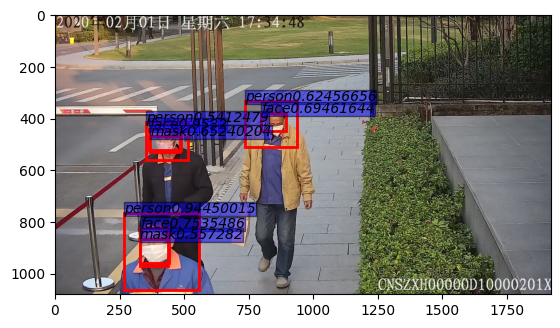

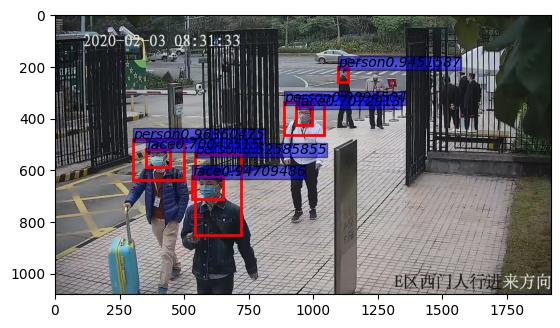

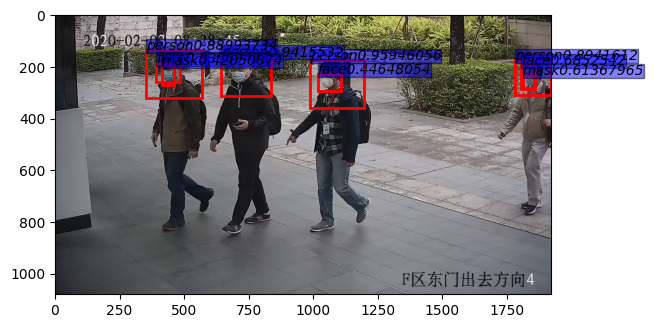

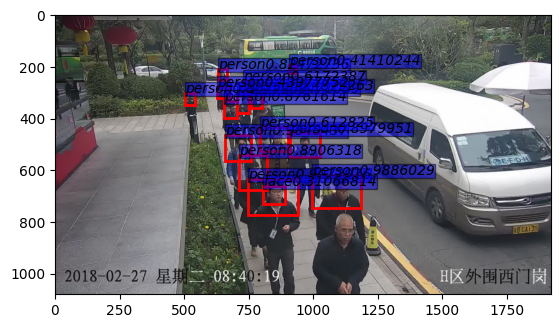

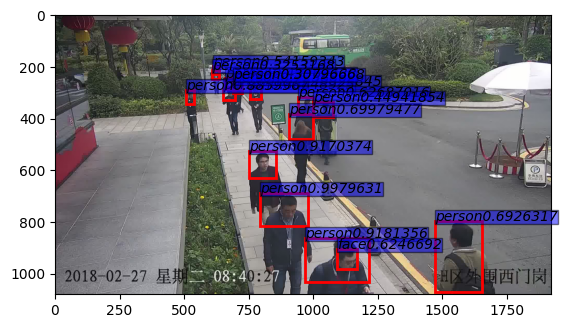

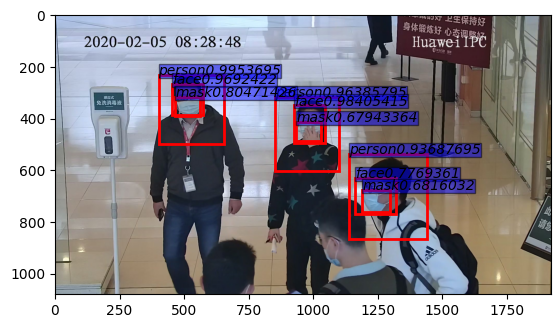

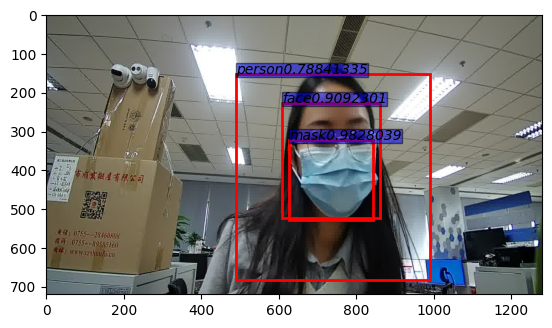

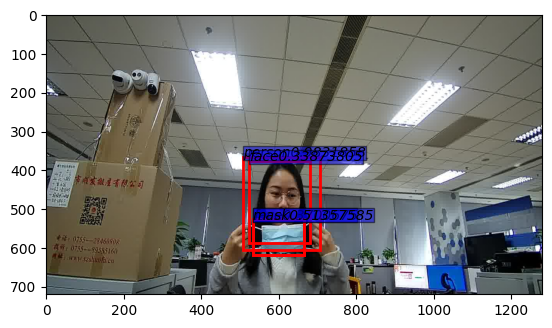

In [10]:
# ---------------yolov3  test-------------------------
cfg = edict({
    "device_id": 0,
    "ckpt_url": './output',   
    "train_url": './testoutput'
})

#context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=cfg.device_id)

ckpt_path = './ckpt/'


cfg.ckpt_path = os.path.join(ckpt_path, "yolov3-60_15.ckpt") #此处文件名需要随实际训练epoch情况修改

data_path = './data/' 

mindrecord_dir_test = os.path.join(data_path,'mindrecord/test')   
prefix = "yolo.mindrecord"
cfg.mindrecord_file = os.path.join(mindrecord_dir_test, prefix)
cfg.image_dir = os.path.join(data_path, "test")
if os.path.exists(mindrecord_dir_test) and os.listdir(mindrecord_dir_test):
    print('The mindrecord file had exists!')
else:
    if not os.path.isdir(mindrecord_dir_test):
        os.makedirs(mindrecord_dir_test)
    prefix = "yolo.mindrecord"
    cfg.mindrecord_file = os.path.join(mindrecord_dir_test, prefix)
    print("Create Mindrecord.")
    data_to_mindrecord_byte_image(cfg.image_dir, mindrecord_dir_test, prefix, 1)
    print("Create Mindrecord Done, at {}".format(mindrecord_dir_test))
print("Start Eval!")

yolo_eval(cfg)